# How to build a neural network to fill the missing part of a handwritten digit using GANs

## Importing all of the dependencies

We will be using numpy, matplotlib, keras, tensorflow, and the tqdm package in this exercise. Here, TensorFlow is used as the backend for Keras. You can install these packages with pip. For the MNIST data, we will be using the dataset available in the keras module with a simple import:

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

from keras.layers import Input, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import UpSampling2D, Flatten, Activation
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras import backend as k

from keras.datasets import mnist

Using TensorFlow backend.


In [5]:
# set seed for reproducibility
seed_val = 9000
np.random.seed(seed_val)
random.seed(seed_val)

## Exploring the data
We will load the MNIST data into our session from the keras module with mnist.load_data(). After doing so, we will print the shape and the size of the dataset, as well as the number of classes and unique labels in the dataset:

In [6]:
(X_train, y_train), (X_test, y_test) =  mnist.load_data()
print('Size of the training_set: ', X_train.shape)
print('Size of the test_set: ', X_test.shape)
print('Shape of each image: ', X_train[0].shape)
print('Total number of classes: ', len(np.unique(y_train)))
print('Unique class labels: ', np.unique(y_train))

Size of the training_set:  (60000, 28, 28)
Size of the test_set:  (10000, 28, 28)
Shape of each image:  (28, 28)
Total number of classes:  10
Unique class labels:  [0 1 2 3 4 5 6 7 8 9]


We have a dataset with 10 different classes and 60,000 images, with each image having a shape of 28*28 and each class having 6,000 images.

Let’s plot and see what the handwritten images look like:

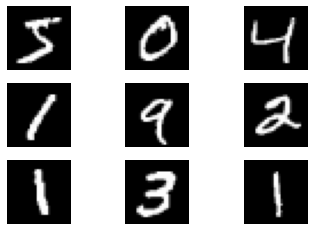

In [7]:
# Plot of 9 random images
for i in range(0, 9):
    plt.subplot(331+i) # plot of 3 rows and 3 columns
    plt.axis('off') # turn off axis
    plt.imshow(X_train[i], cmap='gray') # gray scale

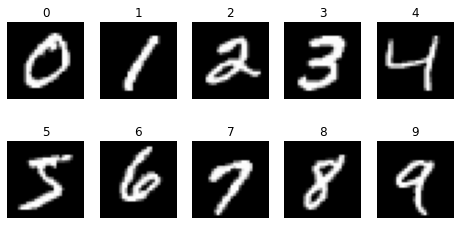

In [8]:
# plotting image from each class
fig=plt.figure(figsize=(8, 4))
columns = 5
rows = 2
for i in range(0, rows*columns):
    fig.add_subplot(rows, columns, i+1)
    plt.title(str(i)) # label 
    plt.axis('off') # turn off axis
    plt.imshow(X_train[np.where(y_train==i)][0], cmap='gray') # gray scale
plt.show()

In [9]:
print('Maximum pixel value in the training_set: ', np.max(X_train))
print('Minimum pixel value in the training_set: ', np.min(X_train))

Maximum pixel value in the training_set:  255
Minimum pixel value in the training_set:  0


Preparing the data
Type conversion, centering, scaling, and reshaping are some of the pre-processing we will implement in this tutorial.

Type conversion, centering and scaling
Set the type to np.float32.

For centering, we subtract the dataset by 127.5. The values in the dataset will now range between -127.5 to 127.5.

For scaling, we divide the centered dataset by half of the maximum pixel value in the dataset, that is, 255/2. This will result in a dataset with values ranging between -1 and 1:

In [10]:
# Converting integer values to float types 
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
# Scaling and centering
X_train = (X_train - 127.5) / 127.5
X_test = (X_test - 127.5)/ 127.5
print('Maximum pixel value in the training_set after Centering and Scaling: ', np.max(X_train))
print('Minimum pixel value in the training_set after Centering and Scaling: ', np.min(X_train))

Maximum pixel value in the training_set after Centering and Scaling:  1.0
Minimum pixel value in the training_set after Centering and Scaling:  -1.0


Maximum pixel value after upscaling scaled image:  255
Maximum pixel value after upscaling scaled image:  0


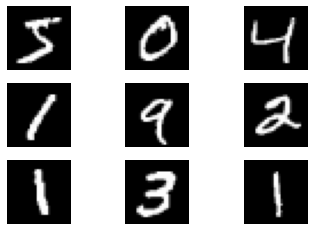

In [11]:
# Rescale the pixel values (0 and 255)
def upscale(image):
    return (image*127.5 + 127.5).astype(np.uint8)
# Lets see if this works
z = upscale(X_train[0])
print('Maximum pixel value after upscaling scaled image: ',np.max(z))
print('Maximum pixel value after upscaling scaled image: ',np.min(z))
#A plot of 9 centered and scaled images after upscaling:

for i in range(0, 9):
    plt.subplot(331+i) # plot of 3 rows and 3 columns
    plt.axis('off') # turn off axis
    plt.imshow(upscale(X_train[i]), cmap='gray') # gray scale

## Masking/inserting noise
For the needs of this project, we need to simulate a dataset of incomplete digits. So, let’s write a function to mask small regions in the original image to form the noised dataset.

The idea is to mask an 8*8 region of the image with the top-left corner of the mask falling between the 9th and 13th pixel (between index 8 and 12) along both the x and y axis of the image. This is to make sure that we are always masking around the center part of the image:

In [12]:
def noising(image):
    array = np.array(image)
    i = random.choice(range(8,12)) # x coordinate for the top left corner of the mask
    j = random.choice(range(8,12)) # y coordinate for the top left corner of the mask
    array[i:i+8, j:j+8]=-1.0 # setting the pixels in the masked region to -1
    return array
noised_train_data = np.array([*map(noising, X_train)])
noised_test_data = np.array([*map(noising, X_test)])
print('Noised train data Shape/Dimension : ', noised_train_data.shape)
print('Noised test data Shape/Dimension : ', noised_train_data.shape)

Noised train data Shape/Dimension :  (60000, 28, 28)
Noised test data Shape/Dimension :  (60000, 28, 28)


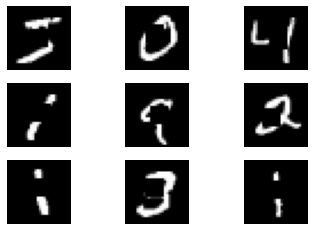

In [13]:
# Plot of 9 scaled noised images after upscaling
for i in range(0, 9):
    plt.subplot(331+i) # plot of 3 rows and 3 columns
    plt.axis('off') # turn off axis
    plt.imshow(upscale(noised_train_data[i]), cmap='gray') # gray scale

## Reshaping
Reshape the original dataset and the noised dataset to a shape of 60000*28*28*1. This is important since the 2D convolutions expect to receive images of a shape of 28*28*1

In [14]:
# Reshaping the training data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
print('Size/Shape of the original training set: ', X_train.shape)
# Reshaping the noised training data
noised_train_data = noised_train_data.reshape(noised_train_data.shape[0],
noised_train_data.shape[1],
noised_train_data.shape[2], 1)
print('Size/Shape of the noised training set: ', noised_train_data.shape)

# Reshaping the testing data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print('Size/Shape of the original test set: ', X_test.shape)

# Reshaping the noised testing data
noised_test_data = noised_test_data.reshape(noised_test_data.shape[0],
noised_test_data.shape[1],
noised_test_data.shape[2], 1)
print('Size/Shape of the noised test set: ', noised_test_data.shape)

Size/Shape of the original training set:  (60000, 28, 28, 1)
Size/Shape of the noised training set:  (60000, 28, 28, 1)
Size/Shape of the original test set:  (10000, 28, 28, 1)
Size/Shape of the noised test set:  (10000, 28, 28, 1)


## MNIST classifier
To start off with modeling, let’s build a simple convolutional neural network (CNN)
digit classifier.

The first layer is a convolution layer that has 32 filters of a shape of 3*3, with relu activation and Dropout as the regularizer. The second layer is a convolution layer that has 64 filters of a shape of 3*3, with relu activation and Dropout as the regularizer. The third layer is a convolution layer that has 128 filters of a shape of 3*3, with relu activation and Dropout as the regularizer, which is finally flattened. The fourth layer is a Dense layer of 1024 neurons with relu activation. The final layer is a Dense layer with 10 neurons corresponding to the 10 classes in the MNIST dataset, and the activation used here is softmax, batch_size is set to 128, the optimizer used is adam, and validation_split is set to 0.2. This means that 20% of the training set will be used as the validation set:

In [15]:
# input image shape
from keras.models import Sequential, Model
input_shape = (28,28,1)
def train_mnist(input_shape, X_train, y_train):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), strides=2, padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), strides=2, padding='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())

    model.add(Dense(1024, activation = 'relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam', metrics = ['accuracy'])
    model.fit(X_train, y_train, batch_size = 128, 
    epochs = 3, validation_split=0.2, verbose = 1 )
    return model

mnist_model = train_mnist(input_shape, X_train, y_train)


Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 60s 1ms/step - loss: 0.2354 - accuracy: 0.9266 - val_loss: 0.0754 - val_accuracy: 0.9764
Epoch 2/3
48000/48000 [==============================] - 59s 1ms/step - loss: 0.0704 - accuracy: 0.9774 - val_loss: 0.0483 - val_accuracy: 0.9858
Epoch 3/3
48000/48000 [==============================] - 60s 1ms/step - loss: 0.0486 - accuracy: 0.9845 - val_loss: 0.0443 - val_accuracy: 0.9872


In [16]:
# prediction on the masked images
pred_labels = mnist_model.predict_classes(noised_test_data)
print('The model model accuracy on the masked images is:',np.mean(pred_labels==y_test)*100)

The model model accuracy on the masked images is: 76.38000000000001


In [17]:
def img_generator(input_shape):
    generator = Sequential()
    generator.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape)) # 32 filters
    generator.add(BatchNormalization())
    generator.add(Activation('relu'))
    generator.add(AveragePooling2D(pool_size=(2, 2)))
    
    generator.add(Conv2D(64, (3, 3), padding='same')) # 64 filters
    generator.add(BatchNormalization())
    generator.add(Activation('relu'))
    generator.add(AveragePooling2D(pool_size=(2, 2)))
    
    generator.add(Conv2D(128, (3, 3), padding='same')) # 128 filters
    generator.add(BatchNormalization())
    generator.add(Activation('relu')) 
    
    generator.add(Conv2D(128, (3, 3), padding='same')) # 128 filters
    generator.add(Activation('relu'))
    generator.add(UpSampling2D((2,2)))
    
    generator.add(Conv2D(64, (3, 3), padding='same')) # 64 filters
    generator.add(Activation('relu'))
    generator.add(UpSampling2D((2,2)))
    
    generator.add(Conv2D(1, (3, 3), activation='tanh', padding='same')) # 1 filter
    return generator

In [18]:
# print generator summary
img_generator(input_shape).summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_4 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
activation_5 (Activation)    (None, 14, 14, 64)       

In [19]:
def img_discriminator(input_shape):
    discriminator = Sequential()
    discriminator.add(Conv2D(64, (3, 3), strides=2, padding='same', input_shape=input_shape, activation = 'linear'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', activation = 'linear'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Conv2D(256, (3, 3), padding='same', activation = 'linear'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))

    return discriminator

# print summary of the discriminator
img_discriminator(input_shape).summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 256)        

In [20]:
def dcgan(discriminator, generator, input_shape):
    # Don't train the discriminator when compiling GAN
    discriminator.trainable = False

    # Accepts the noised input
    gan_input = Input(shape=input_shape)
    
    # Generates image by passing the above received input to the generator
    gen_img = generator(gan_input)
    
    # Feeds the generated image to the discriminator
    gan_output = discriminator(gen_img)
    
    # Compile everything as a model with binary crossentropy loss
    gan = Model(inputs=gan_input, outputs=gan_output)
    return gan

## Building the GAN model components
With the idea that the final GAN model will be able to fill in the part of the image that is missing (masked), let’s define the generator. You can understand how to define the generator, discriminator, and DCGAN by referring to our book.

## Training GAN
We’ve built the components of the GAN.  Let’s train the model in the next steps!

### Plotting the training – part 1
During each epoch, the following function plots 9 generated images. For comparison, it will also plot the corresponding 9 original target images and 9 noised input images. We need to use the upscale function we’ve defined when plotting to make sure the images are scaled to range between 0 and 255, so that you do not encounter issues when plotting:

In [21]:
def generated_images_plot(original, noised_data, generator):
    
    print('NOISED')
    for i in range(9):
        plt.subplot(331 + i)
        plt.axis('off')
        plt.imshow(upscale(np.squeeze(noised_data[i])), cmap='gray') # upscale for plotting
    plt.show()
    
    print('GENERATED')
    for i in range(9):
        pred = generator.predict(noised_data[i:i+1], verbose=0)
        plt.subplot(331 + i)
        plt.axis('off')
        plt.imshow(upscale(np.squeeze(pred[0])), cmap='gray') # upscale to avoid plotting errors
    plt.show()
    
    print('ORIGINAL')
    for i in range(9):
        plt.subplot(331 + i)
        plt.axis('off')
        plt.imshow(upscale(np.squeeze(original[i])), cmap='gray') # upscale for plotting
    plt.show()

### Plotting the training – part 2
Let’s define another function that plots the images generated during each epoch. To reflect the difference, we will also include the original and the masked/noised images in the plot.

The top row contains the original images, the middle row contains the masked images, and the bottom row contains the generated images.

The plot has 12 rows with the sequence, row 1 – original, row 2 – masked, row3 – generated, row 4 – original, row5 – masked,…, row 12 – generated.

In [22]:
def plot_generated_images_combined(original, noised_data, generator):
    rows, cols = 4, 12
    num = rows * cols
    image_size = 28

    generated_images = generator.predict(noised_data[0:num])
    
    imgs = np.concatenate([original[0:num], noised_data[0:num], generated_images])
    imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
    imgs = np.vstack(np.split(imgs, rows, axis=1))
    imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
    imgs = np.vstack([np.hstack(i) for i in imgs])
    imgs = upscale(imgs)
    plt.figure(figsize=(8,16))
    plt.axis('off')
    plt.title('Original Images: top rows, '
              'Corrupted Input: middle rows, '
              'Generated Images: bottom rows')
    plt.imshow(imgs, cmap='gray')
    plt.show()

## Training loop
Now we are at the most important part of the code; the part where all of the functions we previously defined will be used. The following are the steps:

Load the generator by calling the img_generator() function.
Load the discriminator by calling the img_discriminator() function and compile it with the binary cross-entropy loss and optimizer as optimizer_d, which we have defined under the hyperparameters section.
Feed the generator and the discriminator to the dcgan() function and compile it with the binary cross-entropy loss and optimizer as optimizer_g, which we have defined under the hyperparameters section.
Create a new batch of original images and masked images. Generate new fake images by feeding the batch of masked images to the generator.
Concatenate the original and generated images so that the first 128 images are all original and the next 128 images are all fake. It is important that you do not shuffle the data here, otherwise it will be hard to train. Label the generated images as 0 and original images as 0.9 instead of 1. This is one-sided label smoothing on the original images. The reason for using label smoothing is to make the network resilient to adversarial examples. It’s called one-sided because we are smoothing labels only for the real images.
Set discriminator.trainable to True to enable training of the discriminator and feed this set of 256 images and their corresponding labels to the discriminator for classification.
Now, set discriminator.trainable to False and feed a new batch of 128 masked images labeled as 1 to the GAN (DCGAN) for classification. It is important to set discriminator.trainable to False to make sure the discriminator is not getting trained while training the generator.
Repeat steps 4 through 7 for the desired number of epochs.
We have placed the plot_generated_images_combined() function and the generated_images_plot() function to  get a plot generated by both functions after the first iteration in the first epoch and after the end of each epoch.
Training loop
Now we are at the most important part of the code; the part where all of the functions we previously defined will be used. The following are the steps:

Load the generator by calling the img_generator() function.
Load the discriminator by calling the img_discriminator() function and compile it with the binary cross-entropy loss and optimizer as optimizer_d, which we have defined under the hyperparameters section.
Feed the generator and the discriminator to the dcgan() function and compile it with the binary cross-entropy loss and optimizer as optimizer_g, which we have defined under the hyperparameters section.
Create a new batch of original images and masked images. Generate new fake images by feeding the batch of masked images to the generator.
Concatenate the original and generated images so that the first 128 images are all original and the next 128 images are all fake. It is important that you do not shuffle the data here, otherwise it will be hard to train. Label the generated images as 0 and original images as 0.9 instead of 1. This is one-sided label smoothing on the original images. The reason for using label smoothing is to make the network resilient to adversarial examples. It’s called one-sided because we are smoothing labels only for the real images.
Set discriminator.trainable to True to enable training of the discriminator and feed this set of 256 images and their corresponding labels to the discriminator for classification.
Now, set discriminator.trainable to False and feed a new batch of 128 masked images labeled as 1 to the GAN (DCGAN) for classification. It is important to set discriminator.trainable to False to make sure the discriminator is not getting trained while training the generator.
Repeat steps 4 through 7 for the desired number of epochs.
We have placed the plot_generated_images_combined() function and the generated_images_plot() function to  get a plot generated by both functions after the first iteration in the first epoch and after the end of each epoch.

Feel free to place these plot functions according to the frequency of plots you need displayed:

  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 1
Iteration - %d 1
NOISED


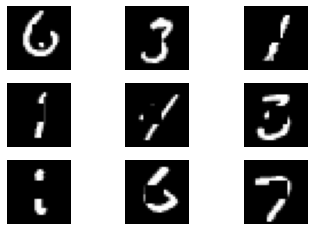

GENERATED


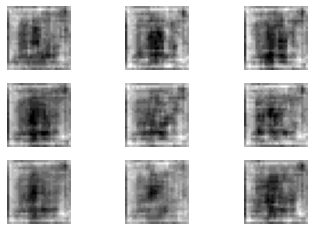

ORIGINAL


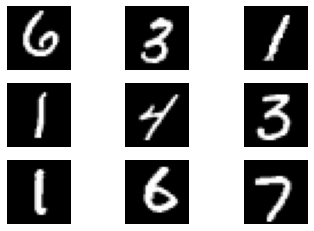

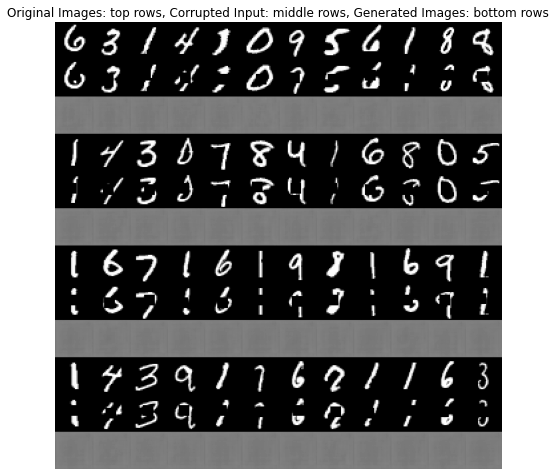

100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [09:52<00:00,  1.27s/it]


Discriminator Loss:  0.4634556 , Adversarial Loss:  1.7415545
NOISED


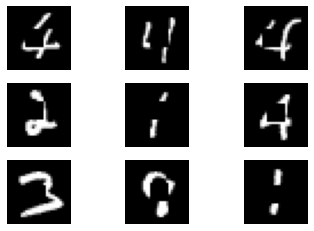

GENERATED


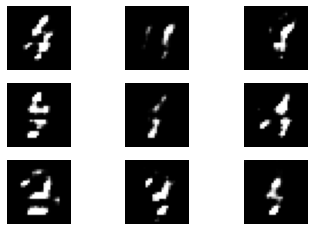

ORIGINAL


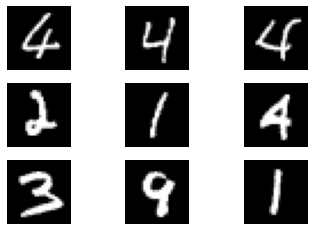

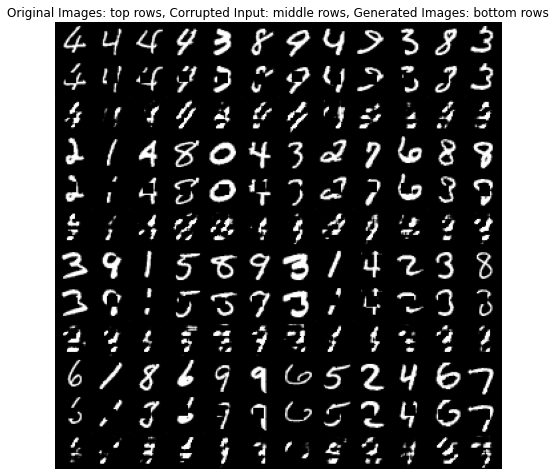

  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 2


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [09:20<00:00,  1.20s/it]


Discriminator Loss:  0.56752 , Adversarial Loss:  1.3907758
NOISED


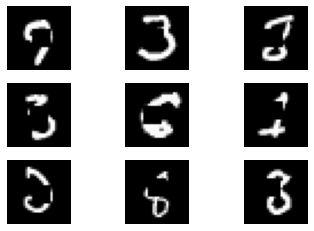

GENERATED


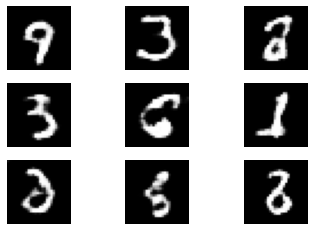

ORIGINAL


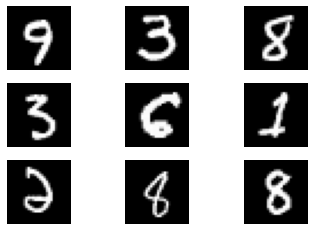

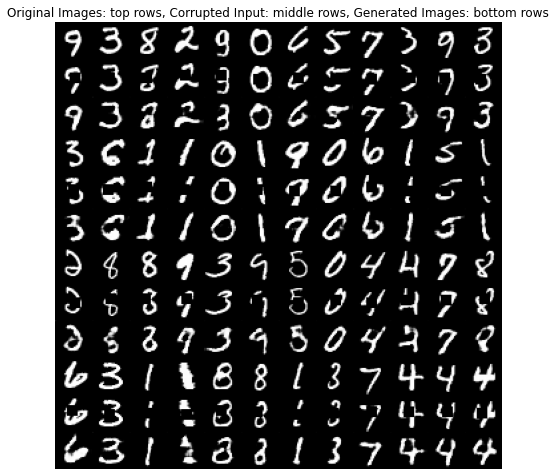

  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 3


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [09:31<00:00,  1.22s/it]


Discriminator Loss:  0.5801862 , Adversarial Loss:  1.2716079
NOISED


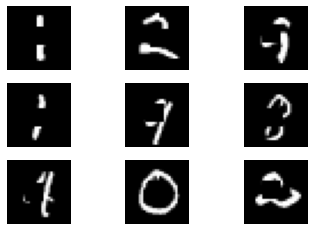

GENERATED


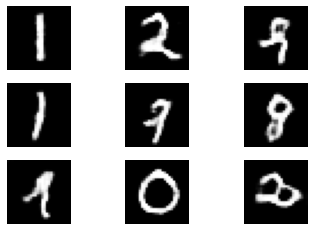

ORIGINAL


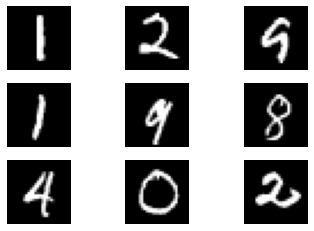

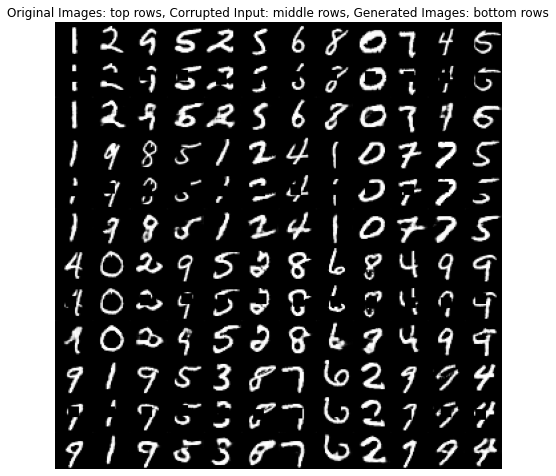

  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 4


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [14:38<00:00,  1.88s/it]


Discriminator Loss:  0.57582676 , Adversarial Loss:  1.3714633
NOISED


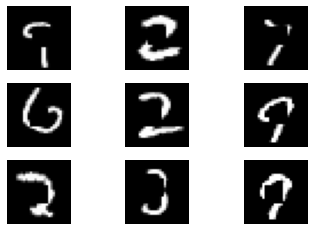

GENERATED


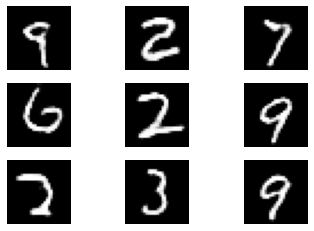

ORIGINAL


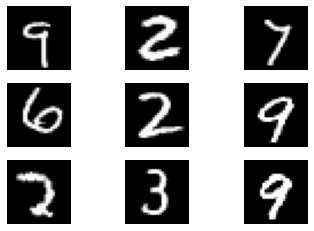

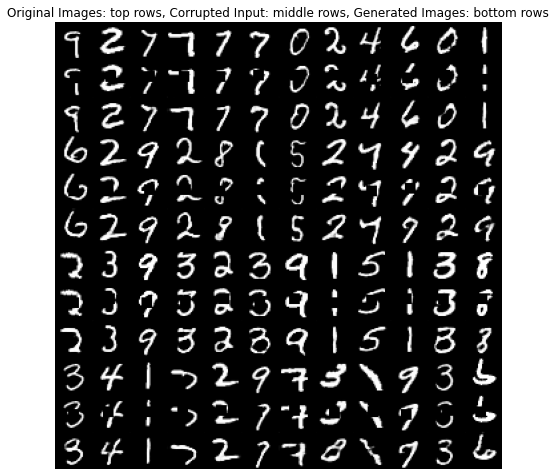

  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 5


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [12:29<00:00,  1.60s/it]


Discriminator Loss:  0.6197982 , Adversarial Loss:  0.8669634
NOISED


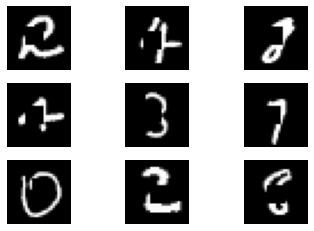

GENERATED


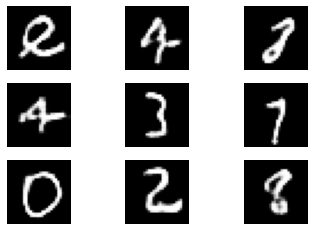

ORIGINAL


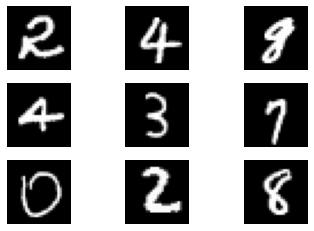

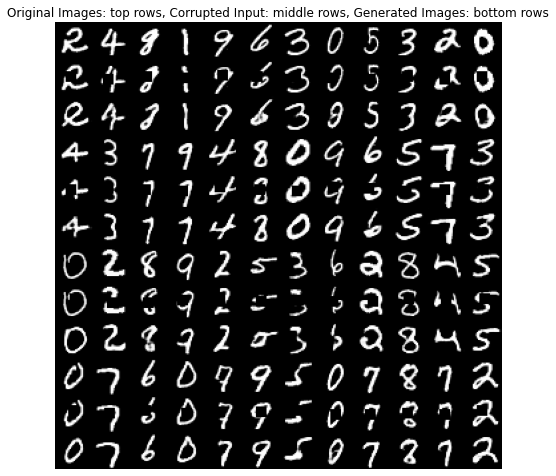

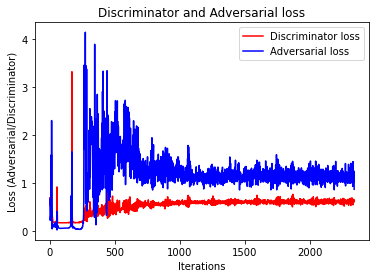

In [24]:
def train(X_train, noised_train_data,
          input_shape, smooth_real,
          epochs, batch_size,
          optimizer_g, optimizer_d):

    # define two empty lists to store the discriminator
    # and the generatoe losses
    discriminator_losses = []
    generator_losses = []
    
    # Number of iteration possible with batches of size 128
    iterations = X_train.shape[0] // batch_size

    # Load the generator and the discriminator
    generator = img_generator(input_shape)
    discriminator = img_discriminator(input_shape)
    
    # Compile the discriminator with binary_crossentropy loss
    discriminator.compile(loss='binary_crossentropy',optimizer=optimizer_d)
    
    # Feed the generator and the discriminator to the function dcgan
    # to form the DCGAN architecture
    gan = dcgan(discriminator, generator, input_shape)
    
    # Compile the DCGAN with binary_crossentropy loss
    gan.compile(loss='binary_crossentropy', optimizer=optimizer_g)

    for i in range(epochs):
        print ('Epoch %d' % (i+1))
        # Use tqdm to get an estimate of time remaining
        for j in tqdm(range(1, iterations+1)):
            
            # batch of original images (batch = batchsize)
            original = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
            
            # batch of noised images (batch = batchsize)
            noise = noised_train_data[np.random.randint(0, noised_train_data.shape[0], size=batch_size)]

            # Generate fake images
            generated_images = generator.predict(noise)
            
            # Labels for generated data
            dis_lab = np.zeros(2*batch_size)
            
            # data for discriminator
            dis_train = np.concatenate([original, generated_images])
            
            # label smoothing for original images
            dis_lab[:batch_size] = smooth_real
            
            # Train discriminator on original iamges
            discriminator.trainable = True
            discriminator_loss = discriminator.train_on_batch(dis_train, dis_lab)
            
            # save the losses 
            discriminator_losses.append(discriminator_loss)
            
            # Train generator
            gen_lab = np.ones(batch_size)
            discriminator.trainable = False
            sample_indices = np.random.randint(0, X_train.shape[0], size=batch_size)
            original = X_train[sample_indices]
            noise = noised_train_data[sample_indices]
            
            generator_loss = gan.train_on_batch(noise, gen_lab)
            
            # save the losses
            generator_losses.append(generator_loss)
            
            if i == 0 and j == 1:
                print('Iteration - %d', j)
                generated_images_plot(original, noise, generator)
                plot_generated_images_combined(original, noise, generator)
        
        print("Discriminator Loss: ", discriminator_loss,\
              ", Adversarial Loss: ", generator_loss)
        
        # training plot 1
        generated_images_plot(original, noise, generator)
        # training plot 2
        plot_generated_images_combined(original, noise, generator)
    
    
    # plot the training losses
    plt.figure()
    plt.plot(range(len(discriminator_losses)), discriminator_losses,
             color='red', label='Discriminator loss')
    plt.plot(range(len(generator_losses)), generator_losses,
             color='blue', label='Adversarial loss')
    plt.title('Discriminator and Adversarial loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss (Adversarial/Discriminator)')
    plt.legend()
    plt.show()
    
    return generator

# Smoothing value
smooth_real = 0.9
# Number of epochs
epochs = 5

# Batchsize
batch_size = 128

# Optimizer for the generator
optimizer_g = Adam(lr=0.0001, beta_1=0.5)

# Optimizer for the discriminator
optimizer_d = Adam(lr=0.0005, beta_1=0.5)

# Shape of the input image
input_shape = (28,28,1)
generator = train(X_train, noised_train_data,
                  input_shape, smooth_real,
                  epochs, batch_size,
                  optimizer_g, optimizer_d)

## Predictions
CNN classifier predictions on the noised and generated images
We will call the generator on the masked MNIST test data to generate images, that is, fill in the missing part of the digits:

In [25]:
gen_imgs_test = generator.predict(noised_test_data)

In [26]:
gen_pred_lab = mnist_model.predict_classes(gen_imgs_test)
print('The model model accuracy on the generated images is:',np.mean(gen_pred_lab==y_test)*100)

The model model accuracy on the generated images is: 87.47


The MNIST CNN classifier is 87.47% accurate on the generated data.

The following is a plot showing 10 generated images by the generator, the actual label of the generated image, and the label predicted by the digit classifier after processing the generated image:

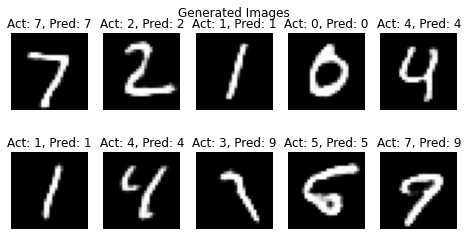

In [27]:
# plot of 10 generated images and their predicted label
fig=plt.figure(figsize=(8, 4))
plt.title('Generated Images')
plt.axis('off') 
columns = 5
rows = 2
for i in range(0, rows*columns):
    fig.add_subplot(rows, columns, i+1)
    plt.title('Act: %d, Pred: %d'%(gen_pred_lab[i],y_test[i])) # label 
    plt.axis('off') # turn off axis
    plt.imshow(upscale(np.squeeze(gen_imgs_test[i])), cmap='gray') # gray scale
plt.show()

The output is as above

Implementation of GAN done by 
ARPITA HALDER
UNIVERSITY ROLL NO. 27600117072 
CSE DEPARTMENT
Under Dr. Pratik Chattopadhyay, Assistant Prof., Dept. of Computer Sci., & Engg., IIT (BHU) During Summer Research Internship